<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/en/thumb/9/9e/Flag_of_Japan.svg/320px-Flag_of_Japan.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition japonaise du *Huff Post* (2013-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 999
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les articles de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Japon"
huff = huff[huff.pays == edition]
huff.shape

(23708, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Ce ne sont pas tous les articles de cette édition du *Huff Post* qui ont, pour nom dans leurs balises `meta`, l'une ou l'autre des éditions du *Huffington Post*, ou de sa compagnie-mère, AOL

In [4]:
huff.meta.value_counts()

HuffPost                    23706
ORICON NEWS                 1    
å¼è­·å£«ãããã³ã     1    
Name: meta, dtype: int64

Créons un sous-ensemble avec les articles qui, selon la balise `meta`, semblent issus du *HP*.

In [5]:
metaHP = huff.meta.str.contains("[H,Η,h][U,u][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]", na=False)
huff[metaHP].meta.value_counts()

HuffPost    23706
Name: meta, dtype: int64

In [6]:
huff[metaHP].shape

(23706, 13)

In [7]:
len(huff) - len(huff[metaHP])

2

Le calcul ci-haut nous indique qu'on a **2 articles** qu'on peut d'ores et déjà ranger dans la catégorie des articles qui ne sont *pas* rédigés par l'équipe du *HuffPost*.
<hr>
Examinons cependant de plus près notre sous-ensemble d'articles dont la balise `meta` prétend qu'ils sont issus du *HuffPost* en regardant qui sont les signataires de ces articles. Les signataires se trouvent dans la colonne `byline`. Voyons voir, donc, ce qu'elle contient.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [8]:
huff[metaHP].byline.value_counts()

? The Huffington Post                                                           5578
| 執筆者： 朝日新聞社提供 Asahi Shimbun                                                    1666
| 執筆者： HuffPost Newsroom The Huffington Post                                    1460
| 執筆者：安藤健二 The Huffington Post                                                  1034
| 執筆者： Reuters Reuters                                                          920 
| 執筆者：中野渉 The Huffington Post                                                   836 
| 執筆者： オリコンNewS ORICON STYLE                                                    833 
| 執筆者：吉野太一郎 The Huffington Post                                                 567 
| 執筆者： ハフポスト日本版編集部 The Huffington Post                                          488 
| 執筆者：吉川慧 The Huffington Post                                                   352 
?                                                                               324 
| 執筆者： 和田千才 The Huffington Post                                  

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans le sous-ensemble `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans le sous-ensemble `inconnu2`.<br>
Ils représentent un peu moins de **2%** du total des articles de cette édition du *Huffington&nbsp;Post*.<br>
Nous allons placer cette proportion dans notre variable `HP_inconnu`.

In [9]:
inconnus1 = huff[metaHP].byline == "? "
inconnus2 = huff[metaHP].byline == "? ?"
HP_inconnu = huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(353, 1.4889488780158597)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [10]:
signeHP = huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][signeHP].shape

(15829, 13)

In [11]:
huff[metaHP][signeHP].byline.value_counts(), huff[metaHP][signeHP].byline.value_counts().count()

(? The Huffington Post                                                                                         5578
 | 執筆者： HuffPost Newsroom The Huffington Post                                                                  1460
 | 執筆者：安藤健二 The Huffington Post                                                                                1034
 | 執筆者：中野渉 The Huffington Post                                                                                 836 
 | 執筆者：吉野太一郎 The Huffington Post                                                                               567 
 | 執筆者： ハフポスト日本版編集部 The Huffington Post                                                                        488 
 | 執筆者：吉川慧 The Huffington Post                                                                                 352 
 | 執筆者： 和田千才 The Huffington Post                                                                               234 
 | 執筆者： Huffpost Newsroom The Huffington Post                           

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **15&nbsp;829 articles** signés par **1&nbsp;046 signataires différents**.<br>
Cela représente près des deux tiers de l'ensemble des articles publiés par cette édition du *HuffPost* dans la période étudiée.
On peut placer cette proportion dans notre variable `HP_oui`.

In [12]:
HP_oui = huff[metaHP][signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(15829, 66.766492323266419)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer un nouveau sous-ensemble qu'on va baptiser `NONsignéHP`.

In [13]:
NONsigneHP = ~huff[metaHP].byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[metaHP][NONsigneHP].shape

(7877, 13)

Qui sont ces auteurs qui ne signent pas des articles originaux pour le *HuffPost*?

In [14]:
huff[metaHP][NONsigneHP].byline.value_counts(), huff[metaHP][NONsigneHP].byline.value_counts().count() 

(| 執筆者： 朝日新聞社提供 Asahi Shimbun                                                                                                             1666
 | 執筆者： Reuters Reuters                                                                                                                   920 
 | 執筆者： オリコンNewS ORICON STYLE                                                                                                             833 
 ?                                                                                                                                        324 
 ? Asahi Shimbun                                                                                                                          192 
 | 執筆者： ロイターニュース編集部 ロイター                                                                                                                  169 
 Chika Igaya ?                                                                                                                            153 

On constate que lorsqu'il y a un nom de journaliste suivi d'un point d'interrogation, c'est un auteur de l'équipe du *HuffPost Italie*. C'est le cas d'[Chika Igaya](http://www.huffingtonpost.jp/author/chika-igaya/) et d'[Taichiro Yoshino](http://www.huffingtonpost.jp/author/taichiro-yoshino/), pour ne nommer que ceux-là.

On va donc considérer que si la variable `byline` se termine par un point d'interrogation, il s'agira d'un auteur qui rédige des articles originaux pour le *HuffPost*.

Isolons ces auteurs.

In [15]:
auteur = huff[metaHP][NONsigneHP].byline.str.endswith(" ?")
huff[metaHP][NONsigneHP][auteur].byline.value_counts(), huff[metaHP][NONsigneHP][auteur].byline.value_counts().sum()

(Chika Igaya ?               153
 吉野太一郎 ?                     102
 中野渉 ?                       72 
 ? ?                         29 
 安藤健二 ?                      29 
 Matt Sheehan ?              14 
 吉川慧 ?                       9  
 和田千才 ?                      9  
 伊藤大地 ?                      9  
 Sophia Jones ?              8  
 宇津宮尚子 ?                     8  
 Yagana Shah ?               7  
 Howard Fineman ?            7  
 Kosuke Takahashi ?          6  
 Gerry Smith ?               5  
 Kate Sheppard ?             5  
 泉谷由梨子 ?                     5  
 Emily Peck ?                4  
 Nick Visser ?               4  
 Dominique Mosbergen ?       4  
 Ed Mazza ?                  4  
 Mehdi Hasan ?               4  
 James Cave ?                4  
 Mark Gongloff ?             4  
 Hunter Stuart ?             4  
 Michael McAuliff ?          4  
 Anna Almendrala ?           3  
 Peter S. Goodman ?          3  
 Amanda L. Chan ?            3  
 Ryan Grim ?                 3  
 Nick Wing

Ces auteurs ont donc signé **661 articles** (690 articles ci-dessus, auxquels il faut retrancher les 29 articles dont l'auteur est inconnu [«&nbsp;? ?&nbsp;»]).

On peut les ajouter à notre variable `HP_oui`.

In [16]:
HP_oui = huff[metaHP][signeHP].pays.count() + 661
HP_oui, (HP_oui/len(huff))*100

(16490, 69.554580732242272)

Pour calculer le pourcentage des articles signés par des auteurs externes, il faut soustraire de notre sous-ensemble `NONsignéHP` les articles contenus dans les deux sous-ensembles `inconnu1` et `inconnu2`, additionner les deux articles qu'on a identifié plus haut dont la balise `meta` ne pouvait pas être associée au *HuffPost*, et retrancher les articles qu'on vient tout juste d'ajouter à notre variable `HP_oui`.

In [17]:
HP_non = huff[metaHP][NONsigneHP].pays.count() - (huff[metaHP][inconnus1].pays.count() + huff[metaHP][inconnus2].pays.count()) + (len(huff) - len(huff[metaHP])) - 661
HP_non, (HP_non/len(huff))*100

(6865, 28.956470389741863)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

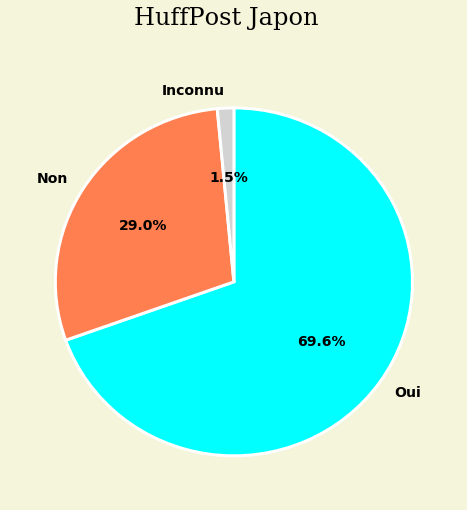

In [18]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Japon", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Exercice boni&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par cette édition.

In [19]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

国際                                   6587
社会                                   5769
エンタメ                                 2846
ライフスタイル                              2400
政治                                   2191
経済                                   1861
lifestyle                            1734
スポーツ                                 960 
テクノロジー                               793 
動画                                   659 
画像                                   559 
アメリカ                                 470 
中国                                   423 
韓国                                   414 
猫                                    396 
イスラム国                                336 
安倍晋三                                 325 
ドナルド・トランプ                            323 
安倍首相                                 314 
ニュース                                 308 
北朝鮮                                  287 
ロシア                                  282 
訃報                                   274 
アベノミクス                            